# Сегментация изображений с помощью U-Net

Датасет скачан с kaggle [Segmentation Full Body MADS Dataset](https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset/code). Первая версия ноутбука разработана М.Гороховым [@magorokhoov](https://github.com/magorokhoov) и послужила основой для [мувика на тюбике](https://www.youtube.com/watch?v=b5Y-hBKSzrw&t=791s). Мне интересно было обучить U-net на PyTorch, и этот ноутбук стал первым шагом в данном направлении.
    
Мои доработки:
- устранение проблемы с чтением файлов изображений; 
- добавление метрик качества и графиков для контроля обучения и переобучения. 

In [1]:
#import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import BinaryAccuracy, BinaryAveragePrecision, BinaryJaccardIndex  #Jaccard Index = IoU metric

import UNet

## Модель U-Net

Михаил подробно рассказывает про построение модели. Я вынес ее в отдельный файл для последующего использоватния в других проектах. Из изменений там замена устаревшей функции upsample на interpolate.

## Подготовка датасета

Набор фотографий и масок скачан с kaggle. Его отличает некоторая вольность в обращении с заголовками png файлов, из-за чего выскакивало неприятное предупреждение.  Предупреждение возникает при использовании библиотеки libpng начиная с версии 1.6.  Можно было бы как-то обработать и перезаписать все png файлы. Я решил заменить библиотеку импорта файлов картинок. 

В исходном варианте использовалась библиотека cv2, которая по видимому и обращается к библиотеке libpng.  Я заменил библиотеку для чтения на pillow и предупреждение об ошибке пропало. В принципе у меня на компьютере pillow чуть быстрее в чтении файлов (4.96 мсек вместо 5.10 мсек). 

С подготовкой картинок для задач компьютерного зрения есть тонкости. Картинки чаще всего читаются в numpy массив формата [строки, столбцы, каналы]. В случае ч/б картинки все три канала могут иметь одно значение или же матрица может быть двумерной.  Для использования такую матрицу надо превратить в трехмерную.  Картинки размерностью 8-бит сохраняются в тип uint8. Каждый пиксель имеет значения 0..255.  Однако для обучения НС их надо преобразовать в плавающие числа float32 и как минимум перевести в диапазон значений 0.0..1.0 делением на 255.0. Многие готовые модели предусматривают номализацию "imagenet" - mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225).  

Кроме того, библиотека PyTorch использует свой порядок размерностей - [каналы, строки, столбцы]. Надо или писать код преобразования в тензор из транспонированного массива, или использовать готовое преобразование из пакета albumentation ToTensorV2. Вместе с библиотекой PyTorch развивается еще и библиотека torchvision, которая выступает конкурентом для albumentation. Однако albumentation существенно выигрывает в скорости. На несложном наборе обработок она обеспечивает длительность обработки порядка 1.38 мСек, а torchvision делает такие же обработки за 9.82 мСек.   

In [2]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,  images_directory, masks_directory, transform=None):
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform
        
        self.images_filenames = sorted([f for f in os.listdir(self.images_directory) if f != '.DS_Store'])

    #def set_transformation(self, transform):
    #    self.transform = transform
        
    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        #print(image_filename)
        #image = cv2.imread(os.path.join(self.images_directory, image_filename), cv2.IMREAD_COLOR)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.asarray(Image.open(os.path.join(self.images_directory, image_filename)).convert('RGB'))
        #mask = cv2.imread(os.path.join(self.masks_directory, image_filename), cv2.IMREAD_COLOR)[:,:,0:1]
        mask = np.expand_dims(np.asarray(Image.open(os.path.join(self.masks_directory, image_filename)).convert('L')),axis=2)
        image = image.astype(np.float32)/255.0
        mask = mask.astype(np.float32)/255.0
        #if self.transform is not None:
        #    transformed = self.transform(image=image, mask=mask)
        #    image = transformed["image"]
        #    mask = transformed["mask"]
        #    mask = np.transpose(mask, (2,0,1))
            #mask = torch.from_numpy(mask)
        return image, mask
    
    

In [3]:
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, data, transformation):
        self.data = data
        self.transform = transformation
    
    def __len__(self):
        return self.data.__len__()
    
    def __getitem__(self, idx):
        image, mask = self.data.__getitem__(idx)
        transformed = self.transform(image=image, mask=mask)
        image = transformed["image"]
        mask = transformed["mask"]
        mask = np.transpose(mask, (2,0,1)) #почему np.transpose для тензора?
        #mask = torch.from_numpy(mask)
        return image, mask        


In [4]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.RandomCrop(256, 256),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.Normalize(mean=(1.0, 1.0, 1.0), std=(1.0, 1.0, 1.0)),
        ToTensorV2(),
    ]
)

valid_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.CenterCrop(256, 256),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [5]:
ds_images_path = './dataset/images/'
ds_masks_path = './dataset/masks/'

dataset = MyDataset(ds_images_path, ds_masks_path) #, transform=train_transform)

In [6]:
# для проверки датасета на отсутствие ошибок можно в цикле прочесть его целиком
#for img, mask in ds_train:
#    pass

Для разделения исходного датасета на обучающую и валидационную (и тестовую) выборки можно использовать метод random_split из библиотеки PyTorch. Надо зафиксировать параметры посева генератора случайных чисел для обеспечения повторяемости.  Метод random_split формирует объект типа subset - поднабор исходного набора. Он отличается наличием списка индексов элементов, относящихся к тому или иному поднабру. 

Хитрость состоит в том, что для обучающего и провеоочного наборов необходимо использовать разные процедуры аугментации.  Традиционный подход с аугментацией внутри getitem() не работает, так как метод изнутри объекта не знает - для какого этапа обучени выдаются данные.  

В принципе можно пойти двумя путями: 
- сделать класс-обертку для поднабора, внутри метода которой и производить необходимую трансоформацию; 
- извлечь список элементов поднабора и проинициализировать им новый тип подкласса, который уже будет на этапе инициации запоминать процедуру трансформации. 

Первый подход проще, и я реализовал его. Второй будет чуть быстрее, но он пришел в голову позже. 

In [7]:
np.random.seed(19)
torch.manual_seed(19) #Обеспечение повторяемости

train_ss, valid_ss = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_ds = TransformedDataset(train_ss, train_transform)
valid_ds = TransformedDataset(valid_ss, valid_transform)

In [12]:
print(f"{os.cpu_count()} CPUs avaliable.")

8 CPUs avaliable.


Если бы в наличии были GPU - можно было бы ускорить процесс загрузки за счет большего количества одновременных потоков. Параметр num_workers можно пропустить для предупреждения ошибок на MacOS, или установить равным количеству доступных процессоров.  

In [8]:
batch_size = 32
#train_loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size, drop_last=True)
#print(f"Total {len(train_loader)} train batches")
train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=False )
valid_loader = torch.utils.data.DataLoader(valid_ds, shuffle=False, batch_size=batch_size, drop_last=False)
print(f" Total {len(train_loader)} train batches and {len(valid_loader)} validation batches.")

 Total 30 train batches and 8 validation batches.


In [9]:
# Для проверки можно прогнать по всем батчам. 
#for img, mask in tqdm(valid_loader): #tqdm(train_loader):
#    pass

In [10]:
#ds_train[0][0].max()

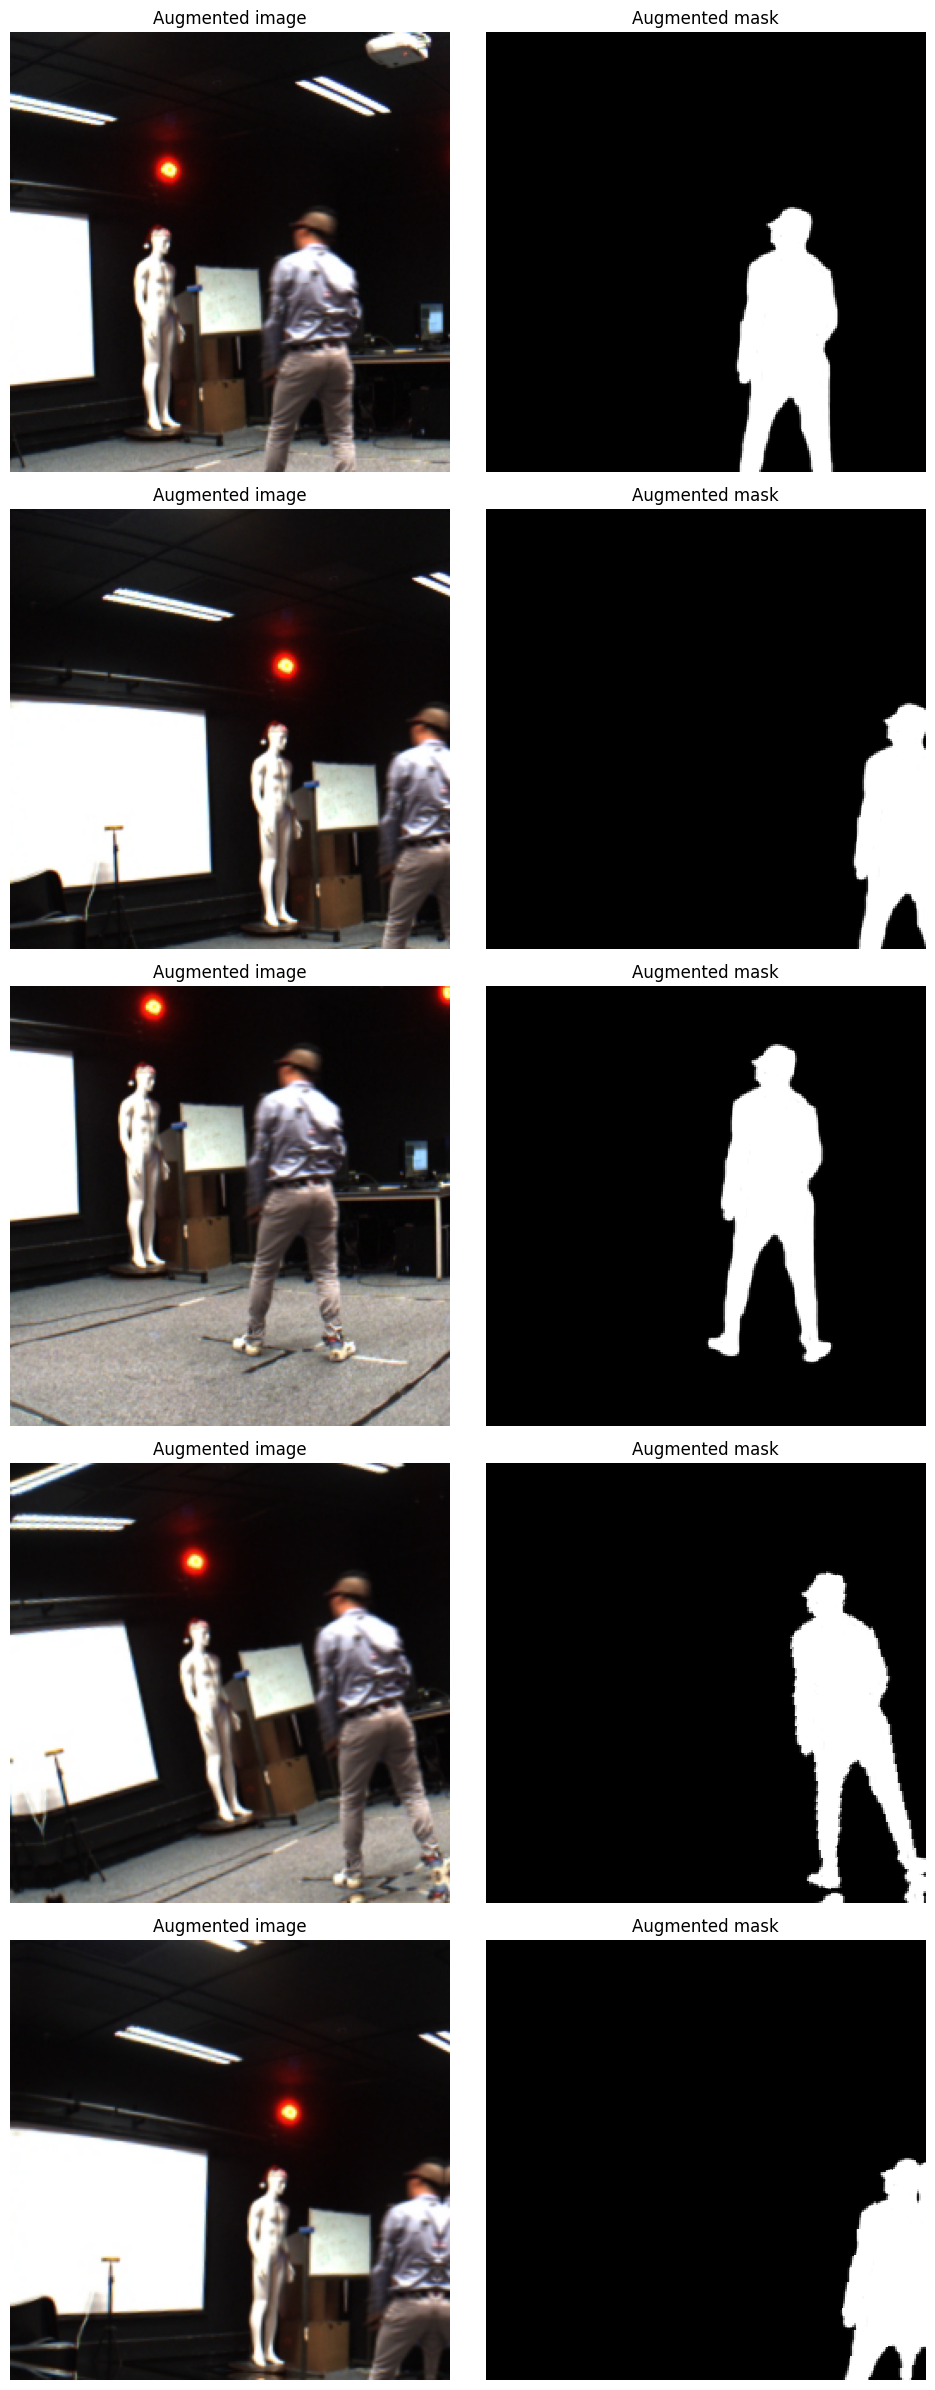

In [38]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        mask = np.transpose(mask, (1,2,0))
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest", cmap=plt.cm.gray)
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_augmentations(train_ds, 0) #

## Создание и обучение модели

In [13]:
device = 'cpu' #'cuda'
unet_model = UNet.Unet(in_nc=3, nc=32, out_nc=1, num_downs=5)
#unet_model = unet_model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


Первоначально я предполагал по инерции в качестве одной из метрик использовать Accuracy. Но она оказалась неинформативной из-за несбалансированности фона и маски объекта, которая занимает много меньше места.  Для сегментации используются метрики mAP (mean Average Precision) и IoU (Jaccard Index). Надо вместо BinaryAccuracy() использовать BinaryAveragePrecision(). У нее есть тонкость - непонятка с threshold. Возможно thresholds = [0.5] 

Тонкость с бинарными метриками. Они требуют чтобы target был целочисленным. 

In [14]:
accuracy = BinaryAccuracy()
jaccard = BinaryJaccardIndex()
mAP = BinaryAveragePrecision(thresholds=[0.5])

In [15]:
#model_new = torch.load('./model/230714_01.pt')
#model_new.eval()

In [16]:
epochs = 25
hist = {'train_loss':[], 'val_loss':[], 
        'train_mAP':[], 'val_mAP':[],
        'train_accuracy':[], 'val_accuracy':[], 
        'train_jaccard':[], 'val_jaccard':[]}
for epoch in range(epochs):
    train_loss = 0
    
    for img, mask in tqdm(train_loader): #(pbar := tqdm(train_loader)):
        #img, mask = sample
        #img = img.to(device)
        #mask = mask.to(device)
        optimizer.zero_grad()
        pred = unet_model(img)
        loss = loss_fn(pred, mask)
        loss.backward()
        train_loss += loss.item()
        mask = mask.round().int()
        #accuracy.update(pred, mask) #Note reversed order
        jaccard.update(pred, mask)
        mAP.update(pred, mask)
        #loss_val += loss_item
        optimizer.step()
        #optimizer.zero_grad()
    #print("-")
    scheduler.step()
    hist['train_loss'].append(train_loss/len(train_loader))
    #hist['train_accuracy'].append(accuracy.compute()) ; accuracy.reset()
    hist['train_jaccard'].append(jaccard.compute()) ; jaccard.reset()
    hist['train_mAP'].append(mAP.compute()) ; mAP.reset()
    
    #for img, mask in tqdm()
    #pbar.set_description(f'loss: {loss_item:.5f}\tlr: {scheduler.get_last_lr}')
    #print(f"Train: {hist['train_loss'][-1]:.4f} loss, {hist['train_accuracy'][-1]:.4f} accuracy, {hist['train_mAP'][-1]:.4f} mAP, {hist['train_jaccard'][-1]:.4f} jaccard index. ")
    print(f"Train: {hist['train_loss'][-1]:.4f} loss, {hist['train_mAP'][-1]:.4f} mAP, {hist['train_jaccard'][-1]:.4f} jaccard index. ")

    val_loss = 0
    unet_model.eval()
    with torch.inference_mode():
        for image, mask in tqdm(valid_loader):
            pred = unet_model(image)
            loss = loss_fn(pred, mask)
            val_loss += loss.item()
            mask = mask.round().int()
            #accuracy.update(pred, mask) #Note reversed order
            jaccard.update(pred, mask)
            mAP.update(pred, mask)
    hist['val_loss'].append(val_loss / len(valid_loader))
    #hist['val_accuracy'].append(accuracy.compute()) ; accuracy.reset()
    hist['val_jaccard'].append(jaccard.compute()) ; jaccard.reset()
    hist['val_mAP'].append(mAP.compute()) ; mAP.reset()
    #print(f"Validation: {hist['val_loss'][-1]:.4f} loss, {hist['val_accuracy'][-1]:.4f} accuracy, {hist['val_mAP'][-1]:.4f} mAP, {hist['val_jaccard'][-1]:.4f} jaccard index")
    print(f"Validation: {hist['val_loss'][-1]:.4f} loss, {hist['val_mAP'][-1]:.4f} mAP, {hist['val_jaccard'][-1]:.4f} jaccard index")


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [10:59<00:00, 21.97s/it]


Train: 0.2861 loss, 0.3557 mAP, 0.4246 jaccard index. 


100%|██████████| 8/8 [00:51<00:00,  6.47s/it]


Validation: 0.4115 loss, 0.0009 mAP, 0.0009 jaccard index


100%|██████████| 30/30 [11:49<00:00, 23.66s/it]


Train: 0.6714 loss, 0.0047 mAP, 0.0282 jaccard index. 


100%|██████████| 8/8 [00:56<00:00,  7.09s/it]


Validation: 0.2848 loss, 0.0000 mAP, 0.0000 jaccard index


100%|██████████| 30/30 [10:40<00:00, 21.36s/it]


Train: 0.2399 loss, 0.0704 mAP, 0.0888 jaccard index. 


100%|██████████| 8/8 [00:57<00:00,  7.18s/it]


Validation: 0.2620 loss, 0.1151 mAP, 0.1217 jaccard index


100%|██████████| 30/30 [10:41<00:00, 21.39s/it]


Train: 0.2161 loss, 0.1834 mAP, 0.2089 jaccard index. 


100%|██████████| 8/8 [00:58<00:00,  7.26s/it]


Validation: 0.2227 loss, 0.2777 mAP, 0.3077 jaccard index


100%|██████████| 30/30 [10:36<00:00, 21.21s/it]


Train: 0.1934 loss, 0.2963 mAP, 0.3357 jaccard index. 


100%|██████████| 8/8 [00:57<00:00,  7.14s/it]


Validation: 0.2021 loss, 0.4063 mAP, 0.4668 jaccard index


100%|██████████| 30/30 [10:34<00:00, 21.16s/it]


Train: 0.1785 loss, 0.3789 mAP, 0.4235 jaccard index. 


100%|██████████| 8/8 [00:58<00:00,  7.32s/it]


Validation: 0.1747 loss, 0.4498 mAP, 0.4747 jaccard index


100%|██████████| 30/30 [10:37<00:00, 21.24s/it]


Train: 0.1472 loss, 0.4780 mAP, 0.5170 jaccard index. 


100%|██████████| 8/8 [00:55<00:00,  6.92s/it]


Validation: 0.1553 loss, 0.5007 mAP, 0.5248 jaccard index


100%|██████████| 30/30 [10:38<00:00, 21.27s/it]


Train: 0.1149 loss, 0.5860 mAP, 0.6170 jaccard index. 


100%|██████████| 8/8 [00:57<00:00,  7.24s/it]


Validation: 0.1082 loss, 0.6291 mAP, 0.6505 jaccard index


100%|██████████| 30/30 [10:36<00:00, 21.23s/it]


Train: 0.0978 loss, 0.6488 mAP, 0.6735 jaccard index. 


100%|██████████| 8/8 [00:56<00:00,  7.05s/it]


Validation: 0.0937 loss, 0.7127 mAP, 0.7302 jaccard index


100%|██████████| 30/30 [10:44<00:00, 21.50s/it]


Train: 0.0799 loss, 0.7222 mAP, 0.7389 jaccard index. 


100%|██████████| 8/8 [00:56<00:00,  7.10s/it]


Validation: 0.0786 loss, 0.7625 mAP, 0.7746 jaccard index


100%|██████████| 30/30 [10:32<00:00, 21.07s/it]


Train: 0.0674 loss, 0.7669 mAP, 0.7789 jaccard index. 


100%|██████████| 8/8 [00:55<00:00,  6.99s/it]


Validation: 0.0734 loss, 0.7838 mAP, 0.7934 jaccard index


100%|██████████| 30/30 [10:31<00:00, 21.04s/it]


Train: 0.0651 loss, 0.7731 mAP, 0.7845 jaccard index. 


100%|██████████| 8/8 [00:57<00:00,  7.14s/it]


Validation: 0.0738 loss, 0.7789 mAP, 0.7882 jaccard index


100%|██████████| 30/30 [10:41<00:00, 21.38s/it]


Train: 0.0595 loss, 0.7886 mAP, 0.7986 jaccard index. 


100%|██████████| 8/8 [00:56<00:00,  7.08s/it]


Validation: 0.0657 loss, 0.8054 mAP, 0.8133 jaccard index


100%|██████████| 30/30 [10:36<00:00, 21.21s/it]


Train: 0.0555 loss, 0.8004 mAP, 0.8093 jaccard index. 


100%|██████████| 8/8 [00:56<00:00,  7.12s/it]


Validation: 0.0639 loss, 0.8050 mAP, 0.8114 jaccard index


100%|██████████| 30/30 [10:39<00:00, 21.33s/it]


Train: 0.0533 loss, 0.8077 mAP, 0.8160 jaccard index. 


100%|██████████| 8/8 [00:56<00:00,  7.03s/it]


Validation: 0.0564 loss, 0.8252 mAP, 0.8314 jaccard index


100%|██████████| 30/30 [10:37<00:00, 21.25s/it]


Train: 0.0491 loss, 0.8195 mAP, 0.8268 jaccard index. 


100%|██████████| 8/8 [00:56<00:00,  7.01s/it]


Validation: 0.0527 loss, 0.8297 mAP, 0.8360 jaccard index


100%|██████████| 30/30 [10:43<00:00, 21.46s/it]


Train: 0.0458 loss, 0.8239 mAP, 0.8308 jaccard index. 


100%|██████████| 8/8 [00:58<00:00,  7.30s/it]


Validation: 0.0511 loss, 0.8347 mAP, 0.8409 jaccard index


100%|██████████| 30/30 [10:44<00:00, 21.48s/it]


Train: 0.0438 loss, 0.8321 mAP, 0.8385 jaccard index. 


100%|██████████| 8/8 [00:57<00:00,  7.14s/it]


Validation: 0.0472 loss, 0.8443 mAP, 0.8498 jaccard index


100%|██████████| 30/30 [10:36<00:00, 21.23s/it]


Train: 0.0483 loss, 0.8181 mAP, 0.8256 jaccard index. 


100%|██████████| 8/8 [00:55<00:00,  6.99s/it]


Validation: 0.0522 loss, 0.8241 mAP, 0.8309 jaccard index


100%|██████████| 30/30 [10:43<00:00, 21.45s/it]


Train: 0.0447 loss, 0.8284 mAP, 0.8351 jaccard index. 


100%|██████████| 8/8 [00:57<00:00,  7.16s/it]


Validation: 0.0493 loss, 0.8355 mAP, 0.8415 jaccard index


100%|██████████| 30/30 [10:40<00:00, 21.34s/it]


Train: 0.0420 loss, 0.8381 mAP, 0.8441 jaccard index. 


100%|██████████| 8/8 [00:57<00:00,  7.19s/it]


Validation: 0.0447 loss, 0.8525 mAP, 0.8575 jaccard index


100%|██████████| 30/30 [10:41<00:00, 21.39s/it]


Train: 0.0407 loss, 0.8403 mAP, 0.8461 jaccard index. 


100%|██████████| 8/8 [00:56<00:00,  7.10s/it]


Validation: 0.0451 loss, 0.8518 mAP, 0.8565 jaccard index


100%|██████████| 30/30 [10:38<00:00, 21.28s/it]


Train: 0.0404 loss, 0.8441 mAP, 0.8497 jaccard index. 


100%|██████████| 8/8 [00:57<00:00,  7.13s/it]


Validation: 0.0451 loss, 0.8522 mAP, 0.8565 jaccard index


100%|██████████| 30/30 [10:38<00:00, 21.29s/it]


Train: 0.0375 loss, 0.8506 mAP, 0.8558 jaccard index. 


100%|██████████| 8/8 [00:55<00:00,  6.98s/it]


Validation: 0.0424 loss, 0.8594 mAP, 0.8640 jaccard index


100%|██████████| 30/30 [10:43<00:00, 21.46s/it]


Train: 0.0384 loss, 0.8519 mAP, 0.8569 jaccard index. 


100%|██████████| 8/8 [00:55<00:00,  7.00s/it]

Validation: 0.0427 loss, 0.8574 mAP, 0.8620 jaccard index


In [17]:
model_name = './model/230715_01.pt'
torch.save(unet_model, model_name)

## Анализ качества обучения и предсказания

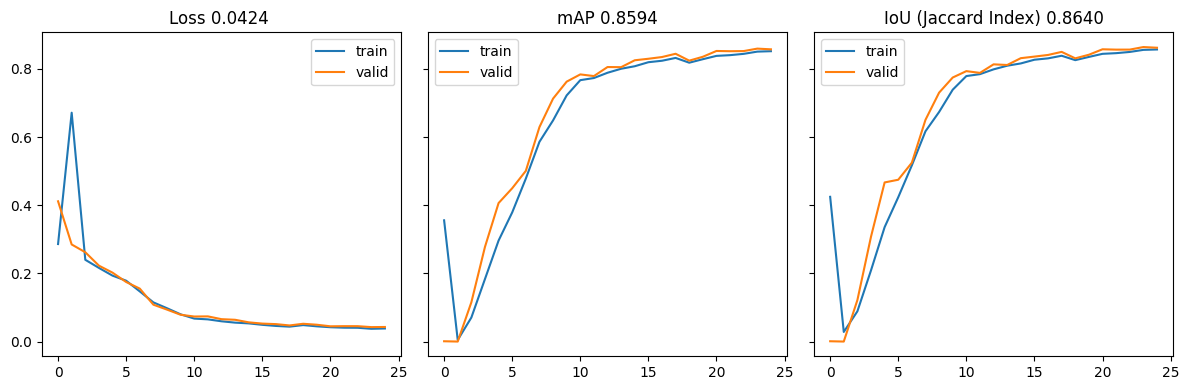

In [19]:
best_loss = min(hist['val_loss'])
best_mAP = max(hist['val_mAP'])
best_jaccard = max(hist['val_jaccard'])

fig, axx = plt.subplots(1,3, figsize=(12,4),sharey=True)
axx[0].plot(hist['train_loss'], label='train')
axx[0].plot(hist['val_loss'], label = 'valid')
axx[0].set_title(f"Loss {best_loss:.4f} ")
axx[0].legend(loc='best')

axx[1].plot(hist['train_mAP'], label = 'train')
axx[1].plot(hist['val_mAP'], label = 'valid')
axx[1].set_title(f"mAP {best_mAP:.4f}")
axx[1].legend(loc='best')

axx[2].plot(hist['train_jaccard'], label = 'train')
axx[2].plot(hist['val_jaccard'], label = 'valid')
axx[2].set_title(f"IoU (Jaccard Index) {best_jaccard:.4f}")
axx[2].legend(loc='best')

plt.tight_layout()
plt.show();
    

Заметен колебательный характер обучения после выхода на плато.  Имеет смысл ввести код для отслеживания наилучшего значения метрики, сохранения и перезаписи модели при достижении нового лучшего значения и раннюю остановку если в течении периода терпения метрика не улучшалась. 

При доработке имеет смысл сохранять не только модель - но и историю показателей ее обучения. Если возникнет желание продолжить обучение модели после перерыва - можно будет дописывать историю к уже имеющейся. 

Для семантической сегментации используются две метрики - mAP и IoU. Они ссодержательно повторяют друг друга.  Есть смысл оставить только одну метрику из двух. 

Для понимания результатов предсказания выводим на экран случайный кадр, исходную маску, предсказанную маску и разницу между предсказанием и исходником. Крайняя картинка возможно самая интересная: 
- черным отрисованы невыделенные пиксели на изображении; 
- белым отрисованы дополнительно выделенные пиксели.  

Sample 19


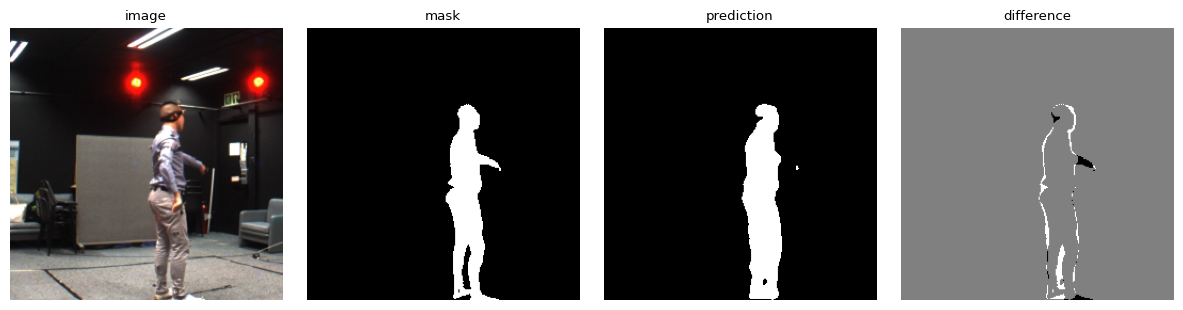

In [50]:
idx = np.random.randint(0,len(valid_ds))
image, mask = valid_ds.__getitem__(idx)
print(f"Sample {idx}")

fig, ax = plt.subplots(1,4, figsize=(12,3))
plt.rcParams["font.size"] = "8"
plt.sca(ax[0])
plt.axis("off")
plt.imshow(image.detach().numpy().transpose(1,2,0));
plt.title("image")

plt.sca(ax[1])
np_mask = mask.squeeze().detach().numpy().astype(np.int16)
plt.imshow(np_mask,cmap=plt.cm.gray );
plt.axis("off")
plt.title("mask")

plt.sca(ax[2])
with torch.inference_mode():
    pred = F.sigmoid(unet_model(image.unsqueeze(0)))
threshold = 0.5
np_pred = np.where(pred.squeeze().detach().numpy()>= threshold, 1, 0) 
plt.imshow(np_pred, cmap=plt.cm.gray)
plt.axis("off")
plt.title("prediction")

plt.sca(ax[3])
diff = ((np_pred - np_mask) + 1)/2
plt.imshow(diff, cmap=plt.cm.gray)
plt.axis("off")
plt.title("difference")
plt.tight_layout()
plt.show();

Соображения по изображениям: 
- Исходные маски содержат много точечного шума, так как размечались с помощью "Фотошопа" а не рисованием вручную. Качество маски и распознавания можно было бы поднять за счет дополнительной обработки маски и предсказания - устранения черных точек, если вокруг нее все белые. 
- Модель плохо делает семантическую сегментацию - осмысляет объект и выделяет фигуру.  В результате она пропускает детали, которые относятся к объекту, но сливаются с фоном, и наоборот - выделяет яркий фон, сливающийся с фигурой.  Фактически реализована сегментация на уровне пикселей, а не запоминания и выделения объекта. 

In [23]:
# старый код с cuda
#img = ds_train[10][0].unsqueeze(0)
#pred = unet_model(img.cuda())
#pred = F.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1,2,0)
#
#img_np = img.detach().cpu().numpy()[0].transpose(1,2,0)
#plt.imshow(img_np)
#
#plt.imshow(pred)